In [22]:
import pandas as pd
import numpy as np
import calendar
from time import time
from datetime import datetime
import re 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
#data_train_orig = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")

In [3]:
dept_list = sorted(list(data_train.DepartmentDescription.dropna().unique()))

In [4]:
weekdays = list(calendar.day_name)
dept_list_sum = dict.fromkeys(dept_list, np.sum)
weekday_dict = dict.fromkeys(weekdays, np.max)
feature_dict = {"TripType": np.max, 'NumItems': np.sum, 'Return': np.max}
feature_dict = {**feature_dict, **weekday_dict, **dept_list_sum}

In [5]:
def transform_data(data):
    dummies = pd.get_dummies(data.Weekday)
    data[dummies.columns] = dummies
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    dummies = dummies.apply(lambda x: x*data["ScanCount"])
    data[dummies.columns] = dummies 

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    
    data = data.rename(columns={"ScanCount":"NumItems"})
    
    grouped = data.groupby("VisitNumber")
    grouped = grouped.aggregate(feature_dict)
    data = grouped[["TripType", "NumItems", "Return"] + weekdays + dept_list]

    return data

In [6]:
data_new = transform_data(data_train)

In [7]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.loc[:, dept_list[0]:]):
        count = 0
        count = sum(x > 0 for x in array)
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [8]:
data_new = add_category_counts(data_new)

In [9]:
data_new.shape

(95674, 78)

In [10]:
def fineline_dummies(data):
    values = data.FinelineNumber
    counts = values.value_counts()
    mask = values.isin(counts[counts > 500].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['fln_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [11]:
start = datetime.now()
fln_dummies = fineline_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:30.842203'

In [12]:
data_new = data_new.join(fln_dummies)

In [13]:
data_new.shape

(95674, 351)

In [14]:
def Upc_dummies(data):
    values = data.Upc
    counts = values.value_counts()
    mask = values.isin(counts[counts > 300].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['upc_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [15]:
start = datetime.now()
upc_dummies = Upc_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:09.122040'

In [16]:
data_new = data_new.join(upc_dummies)

In [17]:
data_new.shape

(95674, 451)

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [19]:
X = data_new.drop('TripType', axis=1)

trip_types = sorted(data_train.TripType.unique())
trip_types_map = dict(zip(trip_types, np.arange(0, len(trip_types))))
y = data_new.TripType.map(trip_types_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
len(X.columns)

450

In [23]:
def create_model_1hl(nodes_l1=512, dropout_l1=0.3):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [24]:
model_1hl = KerasClassifier(build_fn=create_model_1hl, epochs=100, batch_size=1000, verbose=2)

In [25]:
callbacks = [EarlyStopping(monitor="val_acc", patience=20), 
             ModelCheckpoint(filepath="best_model.h5", monitor="val_acc", save_best_only=True)]

In [26]:
start = datetime.now()
hist_1hl = model_1hl.fit(X, y, validation_split=0.25, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

W0909 12:49:15.959316 25548 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
W0909 12:49:16.203315 25548 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 12:49:16.233297 25548 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 12:49:16.273272 25548 depre

Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 7s - loss: 2.0219 - acc: 0.5237 - val_loss: 1.3091 - val_acc: 0.6542
Epoch 2/100
 - 6s - loss: 1.1955 - acc: 0.6585 - val_loss: 1.0318 - val_acc: 0.6895
Epoch 3/100
 - 6s - loss: 1.0214 - acc: 0.6883 - val_loss: 0.9423 - val_acc: 0.7037
Epoch 4/100
 - 6s - loss: 0.9376 - acc: 0.7031 - val_loss: 0.8939 - val_acc: 0.7134
Epoch 5/100
 - 6s - loss: 0.8839 - acc: 0.7142 - val_loss: 0.8693 - val_acc: 0.7142
Epoch 6/100
 - 6s - loss: 0.8446 - acc: 0.7220 - val_loss: 0.8415 - val_acc: 0.7203
Epoch 7/100
 - 6s - loss: 0.8140 - acc: 0.7278 - val_loss: 0.8312 - val_acc: 0.7239
Epoch 8/100
 - 6s - loss: 0.7867 - acc: 0.7363 - val_loss: 0.8204 - val_acc: 0.7259
Epoch 9/100
 - 6s - loss: 0.7671 - acc: 0.7401 - val_loss: 0.8089 - val_acc: 0.7259
Epoch 10/100
 - 6s - loss: 0.7479 - acc: 0.7461 - val_loss: 0.8032 - val_acc: 0.7256
Epoch 11/100
 - 6s - loss: 0.7317 - acc: 0.7509 - val_loss: 0.8034 - val_acc: 0.7277
Epoch 12/100
 - 6s - los

'0:05:30.926195'

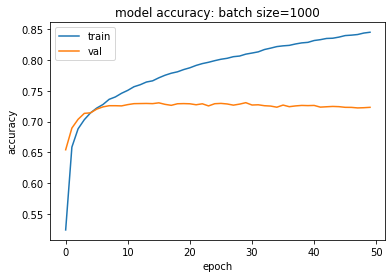

In [95]:
plt.plot(hist_1hl.history['acc'])
plt.plot(hist_1hl.history['val_acc'])
plt.title('model accuracy: batch size=1000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

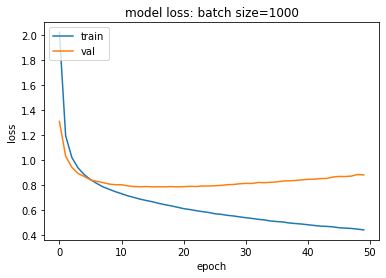

In [96]:
plt.plot(hist_1hl.history['loss'])
plt.plot(hist_1hl.history['val_loss'])
plt.title('model loss: batch size=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
scoring = ['accuracy', 'neg_log_loss']
cv = StratifiedKFold(n_splits=4)

In [31]:
nn_1hl = KerasClassifier(build_fn=create_model_1hl, epochs=20, batch_size=1000, verbose=2)

In [32]:
start = datetime.now()
hist_cross_val = cross_validate(nn_1hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 6s - loss: 2.0192 - acc: 0.5242
Epoch 2/20
 - 7s - loss: 1.2013 - acc: 0.6590
Epoch 3/20
 - 6s - loss: 1.0234 - acc: 0.6891
Epoch 4/20
 - 6s - loss: 0.9453 - acc: 0.7016
Epoch 5/20
 - 6s - loss: 0.8877 - acc: 0.7127
Epoch 6/20
 - 6s - loss: 0.8480 - acc: 0.7209
Epoch 7/20
 - 6s - loss: 0.8185 - acc: 0.7274
Epoch 8/20
 - 6s - loss: 0.7901 - acc: 0.7352
Epoch 9/20
 - 5s - loss: 0.7693 - acc: 0.7399
Epoch 10/20
 - 7s - loss: 0.7498 - acc: 0.7452
Epoch 11/20
 - 6s - loss: 0.7331 - acc: 0.7498
Epoch 12/20
 - 6s - loss: 0.7174 - acc: 0.7554
Epoch 13/20
 - 6s - loss: 0.7037 - acc: 0.7589
Epoch 14/20
 - 5s - loss: 0.6898 - acc: 0.7644
Epoch 15/20
 - 6s - loss: 0.6773 - acc: 0.7651
Epoch 16/20
 - 7s - loss: 0.6641 - acc: 0.7707
Epoch 17/20
 - 6s - loss: 0.6535 - acc: 0.7744
Epoch 18/20
 - 6s - loss: 0.6435 - acc: 0.7767
Epoch 19/20
 - 5s - loss: 0.6353 - acc: 0.7807
Epoch 20/20
 - 5s - loss: 0.6231 - acc: 0.7844


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 7s - loss: 2.0357 - acc: 0.5299
Epoch 2/20
 - 5s - loss: 1.2003 - acc: 0.6589
Epoch 3/20
 - 7s - loss: 1.0239 - acc: 0.6866
Epoch 4/20
 - 6s - loss: 0.9417 - acc: 0.7038
Epoch 5/20
 - 7s - loss: 0.8873 - acc: 0.7133
Epoch 6/20
 - 7s - loss: 0.8477 - acc: 0.7225
Epoch 7/20
 - 6s - loss: 0.8150 - acc: 0.7292
Epoch 8/20
 - 7s - loss: 0.7900 - acc: 0.7360
Epoch 9/20
 - 7s - loss: 0.7681 - acc: 0.7423
Epoch 10/20
 - 7s - loss: 0.7500 - acc: 0.7459
Epoch 11/20
 - 6s - loss: 0.7317 - acc: 0.7516
Epoch 12/20
 - 6s - loss: 0.7164 - acc: 0.7544
Epoch 13/20
 - 8s - loss: 0.7041 - acc: 0.7579
Epoch 14/20
 - 6s - loss: 0.6894 - acc: 0.7641
Epoch 15/20
 - 5s - loss: 0.6776 - acc: 0.7659
Epoch 16/20
 - 7s - loss: 0.6671 - acc: 0.7701
Epoch 17/20
 - 5s - loss: 0.6559 - acc: 0.7737
Epoch 18/20
 - 5s - loss: 0.6429 - acc: 0.7788
Epoch 19/20
 - 6s - loss: 0.6329 - acc: 0.7814
Epoch 20/20
 - 5s - loss: 0.6234 - acc: 0.7833


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 6s - loss: 2.0304 - acc: 0.5225
Epoch 2/20
 - 5s - loss: 1.1861 - acc: 0.6612
Epoch 3/20
 - 6s - loss: 1.0063 - acc: 0.6932
Epoch 4/20
 - 6s - loss: 0.9261 - acc: 0.7081
Epoch 5/20
 - 7s - loss: 0.8715 - acc: 0.7183
Epoch 6/20
 - 6s - loss: 0.8305 - acc: 0.7262
Epoch 7/20
 - 6s - loss: 0.7993 - acc: 0.7339
Epoch 8/20
 - 6s - loss: 0.7748 - acc: 0.7398
Epoch 9/20
 - 8s - loss: 0.7524 - acc: 0.7443
Epoch 10/20
 - 7s - loss: 0.7323 - acc: 0.7513
Epoch 11/20
 - 7s - loss: 0.7146 - acc: 0.7556
Epoch 12/20
 - 6s - loss: 0.7019 - acc: 0.7593
Epoch 13/20
 - 6s - loss: 0.6863 - acc: 0.7641
Epoch 14/20
 - 6s - loss: 0.6726 - acc: 0.7679
Epoch 15/20
 - 6s - loss: 0.6615 - acc: 0.7729
Epoch 16/20
 - 7s - loss: 0.6477 - acc: 0.7759
Epoch 17/20
 - 6s - loss: 0.6383 - acc: 0.7788
Epoch 18/20
 - 7s - loss: 0.6280 - acc: 0.7822
Epoch 19/20
 - 6s - loss: 0.6183 - acc: 0.7851
Epoch 20/20
 - 5s - loss: 0.6097 - acc: 0.7885


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 7s - loss: 2.0178 - acc: 0.5319
Epoch 2/20
 - 6s - loss: 1.1969 - acc: 0.6569
Epoch 3/20
 - 6s - loss: 1.0225 - acc: 0.6864
Epoch 4/20
 - 6s - loss: 0.9380 - acc: 0.7011
Epoch 5/20
 - 6s - loss: 0.8845 - acc: 0.7130
Epoch 6/20
 - 8s - loss: 0.8450 - acc: 0.7208
Epoch 7/20
 - 7s - loss: 0.8132 - acc: 0.7287
Epoch 8/20
 - 8s - loss: 0.7889 - acc: 0.7343
Epoch 9/20
 - 5s - loss: 0.7687 - acc: 0.7396
Epoch 10/20
 - 6s - loss: 0.7479 - acc: 0.7457
Epoch 11/20
 - 5s - loss: 0.7320 - acc: 0.7509
Epoch 12/20
 - 5s - loss: 0.7167 - acc: 0.7553
Epoch 13/20
 - 5s - loss: 0.7014 - acc: 0.7583
Epoch 14/20
 - 5s - loss: 0.6896 - acc: 0.7621
Epoch 15/20
 - 5s - loss: 0.6770 - acc: 0.7677
Epoch 16/20
 - 5s - loss: 0.6645 - acc: 0.7706
Epoch 17/20
 - 5s - loss: 0.6539 - acc: 0.7729
Epoch 18/20
 - 5s - loss: 0.6422 - acc: 0.7792
Epoch 19/20
 - 6s - loss: 0.6340 - acc: 0.7814
Epoch 20/20
 - 5s - loss: 0.6248 - acc: 0.7844


'0:08:20.520567'

In [33]:
hist_cross_val

{'fit_time': array([121.30592537, 125.88338017, 126.39506435, 119.92405462]),
 'score_time': array([2.09670615, 1.42212415, 1.49607825, 1.71794009]),
 'test_accuracy': array([0.72498224, 0.72375737, 0.71694405, 0.72918932]),
 'test_neg_log_loss': array([-0.81106142, -0.80622394, -0.85762089, -0.7897483 ])}

In [34]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7237182461154875, -0.8161636390834985)

In [35]:
nn_1hl = KerasClassifier(build_fn=create_model_1hl, epochs=30, batch_size=1000, verbose=2)

In [36]:
start = datetime.now()
hist_cross_val = cross_validate(nn_1hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 7s - loss: 2.0330 - acc: 0.5220
Epoch 2/30
 - 6s - loss: 1.1959 - acc: 0.6596
Epoch 3/30
 - 6s - loss: 1.0222 - acc: 0.6855
Epoch 4/30
 - 6s - loss: 0.9405 - acc: 0.7034
Epoch 5/30
 - 5s - loss: 0.8864 - acc: 0.7145
Epoch 6/30
 - 6s - loss: 0.8471 - acc: 0.7221
Epoch 7/30
 - 7s - loss: 0.8172 - acc: 0.7296
Epoch 8/30
 - 7s - loss: 0.7895 - acc: 0.7350
Epoch 9/30
 - 8s - loss: 0.7674 - acc: 0.7403
Epoch 10/30
 - 7s - loss: 0.7495 - acc: 0.7475
Epoch 11/30
 - 6s - loss: 0.7303 - acc: 0.7514
Epoch 12/30
 - 6s - loss: 0.7145 - acc: 0.7562
Epoch 13/30
 - 6s - loss: 0.7018 - acc: 0.7593
Epoch 14/30
 - 8s - loss: 0.6881 - acc: 0.7634
Epoch 15/30
 - 7s - loss: 0.6754 - acc: 0.7662
Epoch 16/30
 - 8s - loss: 0.6634 - acc: 0.7712
Epoch 17/30
 - 8s - loss: 0.6532 - acc: 0.7737
Epoch 18/30
 - 6s - loss: 0.6432 - acc: 0.7775
Epoch 19/30
 - 5s - loss: 0.6334 - acc: 0.7816
Epoch 20/30
 - 5s - loss: 0.6237 - acc: 0.7839
Epoch 21/30
 - 6s - loss: 0.6150 - acc: 0.7862
Epoch 22/30
 - 6s - lo

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 5s - loss: 2.0059 - acc: 0.5271
Epoch 2/30
 - 6s - loss: 1.1929 - acc: 0.6576
Epoch 3/30
 - 5s - loss: 1.0201 - acc: 0.6879
Epoch 4/30
 - 5s - loss: 0.9390 - acc: 0.7034
Epoch 5/30
 - 6s - loss: 0.8851 - acc: 0.7141
Epoch 6/30
 - 5s - loss: 0.8445 - acc: 0.7229
Epoch 7/30
 - 5s - loss: 0.8135 - acc: 0.7304
Epoch 8/30
 - 6s - loss: 0.7880 - acc: 0.7357
Epoch 9/30
 - 5s - loss: 0.7672 - acc: 0.7413
Epoch 10/30
 - 5s - loss: 0.7468 - acc: 0.7463
Epoch 11/30
 - 6s - loss: 0.7315 - acc: 0.7503
Epoch 12/30
 - 5s - loss: 0.7161 - acc: 0.7552
Epoch 13/30
 - 6s - loss: 0.7003 - acc: 0.7601
Epoch 14/30
 - 8s - loss: 0.6879 - acc: 0.7638
Epoch 15/30
 - 5s - loss: 0.6752 - acc: 0.7688
Epoch 16/30
 - 5s - loss: 0.6639 - acc: 0.7706
Epoch 17/30
 - 5s - loss: 0.6534 - acc: 0.7732
Epoch 18/30
 - 5s - loss: 0.6430 - acc: 0.7777
Epoch 19/30
 - 5s - loss: 0.6325 - acc: 0.7807
Epoch 20/30
 - 6s - loss: 0.6253 - acc: 0.7833
Epoch 21/30
 - 5s - loss: 0.6142 - acc: 0.7877
Epoch 22/30
 - 6s - lo

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 6s - loss: 2.0500 - acc: 0.5191
Epoch 2/30
 - 5s - loss: 1.1937 - acc: 0.6593
Epoch 3/30
 - 6s - loss: 1.0174 - acc: 0.6901
Epoch 4/30
 - 5s - loss: 0.9323 - acc: 0.7074
Epoch 5/30
 - 5s - loss: 0.8764 - acc: 0.7178
Epoch 6/30
 - 7s - loss: 0.8340 - acc: 0.7269
Epoch 7/30
 - 8s - loss: 0.8033 - acc: 0.7338
Epoch 8/30
 - 9s - loss: 0.7765 - acc: 0.7403
Epoch 9/30
 - 9s - loss: 0.7531 - acc: 0.7451
Epoch 10/30
 - 10s - loss: 0.7354 - acc: 0.7504
Epoch 11/30
 - 9s - loss: 0.7176 - acc: 0.7562
Epoch 12/30
 - 11s - loss: 0.7030 - acc: 0.7586
Epoch 13/30
 - 9s - loss: 0.6883 - acc: 0.7616
Epoch 14/30
 - 9s - loss: 0.6767 - acc: 0.7655
Epoch 15/30
 - 12s - loss: 0.6619 - acc: 0.7716
Epoch 16/30
 - 9s - loss: 0.6514 - acc: 0.7748
Epoch 17/30
 - 11s - loss: 0.6405 - acc: 0.7794
Epoch 18/30
 - 11s - loss: 0.6295 - acc: 0.7821
Epoch 19/30
 - 10s - loss: 0.6194 - acc: 0.7843
Epoch 20/30
 - 8s - loss: 0.6102 - acc: 0.7883
Epoch 21/30
 - 10s - loss: 0.6006 - acc: 0.7914
Epoch 22/30
 - 

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 11s - loss: 2.0132 - acc: 0.5343
Epoch 2/30
 - 8s - loss: 1.1969 - acc: 0.6560
Epoch 3/30
 - 8s - loss: 1.0196 - acc: 0.6864
Epoch 4/30
 - 8s - loss: 0.9371 - acc: 0.7033
Epoch 5/30
 - 8s - loss: 0.8848 - acc: 0.7136
Epoch 6/30
 - 8s - loss: 0.8442 - acc: 0.7214
Epoch 7/30
 - 8s - loss: 0.8141 - acc: 0.7298
Epoch 8/30
 - 7s - loss: 0.7893 - acc: 0.7349
Epoch 9/30
 - 8s - loss: 0.7675 - acc: 0.7399
Epoch 10/30
 - 7s - loss: 0.7509 - acc: 0.7441
Epoch 11/30
 - 8s - loss: 0.7302 - acc: 0.7498
Epoch 12/30
 - 8s - loss: 0.7164 - acc: 0.7544
Epoch 13/30
 - 10s - loss: 0.7013 - acc: 0.7595
Epoch 14/30
 - 8s - loss: 0.6896 - acc: 0.7628
Epoch 15/30
 - 9s - loss: 0.6767 - acc: 0.7670
Epoch 16/30
 - 10s - loss: 0.6642 - acc: 0.7707
Epoch 17/30
 - 8s - loss: 0.6541 - acc: 0.7750
Epoch 18/30
 - 8s - loss: 0.6441 - acc: 0.7774
Epoch 19/30
 - 8s - loss: 0.6350 - acc: 0.7802
Epoch 20/30
 - 8s - loss: 0.6254 - acc: 0.7829
Epoch 21/30
 - 8s - loss: 0.6135 - acc: 0.7872
Epoch 22/30
 - 9s -

'0:14:44.436983'

In [37]:
hist_cross_val

{'fit_time': array([186.56425929, 165.83277106, 265.46831584, 257.24738407]),
 'score_time': array([1.52905774, 1.95479488, 3.42688799, 2.20863795]),
 'test_accuracy': array([0.72565078, 0.72693449, 0.71698587, 0.72663766]),
 'test_neg_log_loss': array([-0.82519258, -0.82373511, -0.88569028, -0.81705462])}

In [38]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7240521994975538, -0.8379181482789095)

In [97]:
def create_model_1hl_v2(nodes_l1=512, dropout_l1=0.3):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="tanh", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
    
    return model

In [98]:
model_1hl_v2 = KerasClassifier(build_fn=create_model_1hl_v2, epochs=100, batch_size=1000, verbose=2)

In [99]:
start = datetime.now()
hist_1hl_v2 = model_1hl_v2.fit(X, y, validation_split=0.25, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="tanh", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 107s - loss: 2.0193 - acc: 0.5197 - val_loss: 1.3578 - val_acc: 0.6322
Epoch 2/100
 - 7s - loss: 1.2652 - acc: 0.6425 - val_loss: 1.1337 - val_acc: 0.6728
Epoch 3/100
 - 7s - loss: 1.1285 - acc: 0.6637 - val_loss: 1.0518 - val_acc: 0.6869
Epoch 4/100
 - 6s - loss: 1.0709 - acc: 0.6754 - val_loss: 1.0111 - val_acc: 0.6973
Epoch 5/100
 - 7s - loss: 1.0389 - acc: 0.6846 - val_loss: 0.9885 - val_acc: 0.6997
Epoch 6/100
 - 7s - loss: 1.0134 - acc: 0.6874 - val_loss: 0.9848 - val_acc: 0.6981
Epoch 7/100
 - 8s - loss: 0.9961 - acc: 0.6929 - val_loss: 0.9608 - val_acc: 0.7053
Epoch 8/100
 - 7s - loss: 0.9799 - acc: 0.6955 - val_loss: 0.9529 - val_acc: 0.7075
Epoch 9/100
 - 7s - loss: 0.9682 - acc: 0.6977 - val_loss: 0.9438 - val_acc: 0.7076
Epoch 10/100
 - 8s - loss: 0.9553 - acc: 0.7002 - val_loss: 0.9269 - val_acc: 0.7142
Epoch 11/100
 - 7s - loss: 0.9487 - acc: 0.7016 - val_loss: 0.9255 - val_acc: 0.7112
Epoch 12/100
 - 8s - l

'0:11:56.049015'

In [55]:
nn_1hl_bsz2000 = KerasClassifier(build_fn=create_model_1hl, epochs=100, batch_size=2000, verbose=2)

In [56]:
start = datetime.now()
hist_1hl_bsz2000 = nn_1hl_bsz2000.fit(X, y, validation_split=0.25, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 13s - loss: 2.4161 - acc: 0.4721 - val_loss: 1.6955 - val_acc: 0.6129
Epoch 2/100
 - 11s - loss: 1.4901 - acc: 0.6216 - val_loss: 1.2364 - val_acc: 0.6661
Epoch 3/100
 - 11s - loss: 1.1941 - acc: 0.6596 - val_loss: 1.0661 - val_acc: 0.6906
Epoch 4/100
 - 11s - loss: 1.0658 - acc: 0.6792 - val_loss: 0.9882 - val_acc: 0.6990
Epoch 5/100
 - 11s - loss: 0.9942 - acc: 0.6921 - val_loss: 0.9412 - val_acc: 0.7068
Epoch 6/100
 - 11s - loss: 0.9403 - acc: 0.7027 - val_loss: 0.9111 - val_acc: 0.7083
Epoch 7/100
 - 11s - loss: 0.9021 - acc: 0.7099 - val_loss: 0.8877 - val_acc: 0.7147
Epoch 8/100
 - 11s - loss: 0.8708 - acc: 0.7182 - val_loss: 0.8647 - val_acc: 0.7198
Epoch 9/100
 - 11s - loss: 0.8420 - acc: 0.7240 - val_loss: 0.8497 - val_acc: 0.7216
Epoch 10/100
 - 11s - loss: 0.8229 - acc: 0.7267 - val_loss: 0.8398 - val_acc: 0.7198
Epoch 11/100
 - 11s - loss: 0.8014 - acc: 0.7334 - val_loss: 0.8293 - val_acc: 0.7231
Epoch 12/100


'0:09:00.802094'

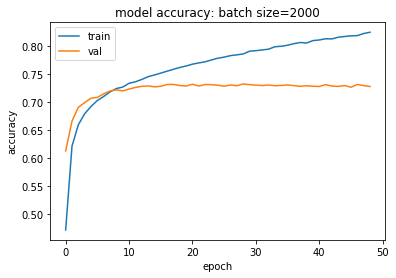

In [93]:
plt.plot(hist_1hl_bsz2000.history['acc'])
plt.plot(hist_1hl_bsz2000.history['val_acc'])
plt.title('model accuracy: batch size=2000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

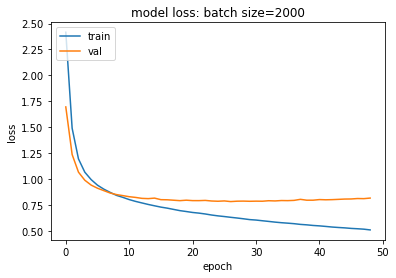

In [94]:
plt.plot(hist_1hl_bsz2000.history['loss'])
plt.plot(hist_1hl_bsz2000.history['val_loss'])
plt.title('model loss: batch size=2000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
nn_1hl_bsz2000 = KerasClassifier(build_fn=create_model_1hl, epochs=30, batch_size=2000, verbose=2)

In [58]:
start = datetime.now()
hist_cross_val_bsz2000 = cross_validate(nn_1hl_bsz2000, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 11s - loss: 2.4104 - acc: 0.4678
Epoch 2/30
 - 10s - loss: 1.4970 - acc: 0.6246
Epoch 3/30
 - 10s - loss: 1.1995 - acc: 0.6589
Epoch 4/30
 - 10s - loss: 1.0675 - acc: 0.6814
Epoch 5/30
 - 10s - loss: 0.9927 - acc: 0.6938
Epoch 6/30
 - 10s - loss: 0.9402 - acc: 0.7036
Epoch 7/30
 - 10s - loss: 0.8997 - acc: 0.7114
Epoch 8/30
 - 10s - loss: 0.8694 - acc: 0.7169
Epoch 9/30
 - 10s - loss: 0.8432 - acc: 0.7231
Epoch 10/30
 - 10s - loss: 0.8211 - acc: 0.7267
Epoch 11/30
 - 10s - loss: 0.7991 - acc: 0.7324
Epoch 12/30
 - 9s - loss: 0.7819 - acc: 0.7380
Epoch 13/30
 - 10s - loss: 0.7680 - acc: 0.7397
Epoch 14/30
 - 10s - loss: 0.7508 - acc: 0.7461
Epoch 15/30
 - 10s - loss: 0.7400 - acc: 0.7488
Epoch 16/30
 - 10s - loss: 0.7266 - acc: 0.7532
Epoch 17/30
 - 10s - loss: 0.7154 - acc: 0.7553
Epoch 18/30
 - 10s - loss: 0.7038 - acc: 0.7593
Epoch 19/30
 - 9s - loss: 0.6940 - acc: 0.7618
Epoch 20/30
 - 10s - loss: 0.6841 - acc: 0.7659
Epoch 21/30
 - 10s - loss: 0.6768 - acc: 0.7665
Epo

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 7s - loss: 2.4107 - acc: 0.4662
Epoch 2/30
 - 5s - loss: 1.4943 - acc: 0.6230
Epoch 3/30
 - 5s - loss: 1.1930 - acc: 0.6611
Epoch 4/30
 - 5s - loss: 1.0604 - acc: 0.6829
Epoch 5/30
 - 5s - loss: 0.9864 - acc: 0.6950
Epoch 6/30
 - 5s - loss: 0.9327 - acc: 0.7053
Epoch 7/30
 - 5s - loss: 0.8962 - acc: 0.7123
Epoch 8/30
 - 5s - loss: 0.8643 - acc: 0.7172
Epoch 9/30
 - 5s - loss: 0.8388 - acc: 0.7233
Epoch 10/30
 - 5s - loss: 0.8155 - acc: 0.7315
Epoch 11/30
 - 5s - loss: 0.7974 - acc: 0.7348
Epoch 12/30
 - 5s - loss: 0.7787 - acc: 0.7395
Epoch 13/30
 - 5s - loss: 0.7626 - acc: 0.7426
Epoch 14/30
 - 6s - loss: 0.7515 - acc: 0.7465
Epoch 15/30
 - 8s - loss: 0.7363 - acc: 0.7507
Epoch 16/30
 - 7s - loss: 0.7247 - acc: 0.7541
Epoch 17/30
 - 8s - loss: 0.7130 - acc: 0.7568
Epoch 18/30
 - 10s - loss: 0.7022 - acc: 0.7597
Epoch 19/30
 - 10s - loss: 0.6906 - acc: 0.7634
Epoch 20/30
 - 10s - loss: 0.6818 - acc: 0.7665
Epoch 21/30
 - 9s - loss: 0.6734 - acc: 0.7704
Epoch 22/30
 - 11s 

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 11s - loss: 2.4485 - acc: 0.4569
Epoch 2/30
 - 10s - loss: 1.4824 - acc: 0.6241
Epoch 3/30
 - 10s - loss: 1.1799 - acc: 0.6635
Epoch 4/30
 - 10s - loss: 1.0471 - acc: 0.6854
Epoch 5/30
 - 10s - loss: 0.9734 - acc: 0.6976
Epoch 6/30
 - 10s - loss: 0.9199 - acc: 0.7096
Epoch 7/30
 - 10s - loss: 0.8832 - acc: 0.7165
Epoch 8/30
 - 9s - loss: 0.8515 - acc: 0.7231
Epoch 9/30
 - 10s - loss: 0.8237 - acc: 0.7293
Epoch 10/30
 - 10s - loss: 0.8012 - acc: 0.7345
Epoch 11/30
 - 10s - loss: 0.7804 - acc: 0.7407
Epoch 12/30
 - 10s - loss: 0.7648 - acc: 0.7426
Epoch 13/30
 - 10s - loss: 0.7483 - acc: 0.7485
Epoch 14/30
 - 10s - loss: 0.7338 - acc: 0.7511
Epoch 15/30
 - 10s - loss: 0.7213 - acc: 0.7549
Epoch 16/30
 - 10s - loss: 0.7094 - acc: 0.7589
Epoch 17/30
 - 10s - loss: 0.6964 - acc: 0.7613
Epoch 18/30
 - 11s - loss: 0.6884 - acc: 0.7650
Epoch 19/30
 - 9s - loss: 0.6780 - acc: 0.7681
Epoch 20/30
 - 10s - loss: 0.6681 - acc: 0.7705
Epoch 21/30
 - 9s - loss: 0.6572 - acc: 0.7740
Epoc

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 12s - loss: 2.4407 - acc: 0.4610
Epoch 2/30
 - 10s - loss: 1.5164 - acc: 0.6170
Epoch 3/30
 - 10s - loss: 1.2116 - acc: 0.6540
Epoch 4/30
 - 10s - loss: 1.0754 - acc: 0.6787
Epoch 5/30
 - 10s - loss: 0.9963 - acc: 0.6923
Epoch 6/30
 - 10s - loss: 0.9441 - acc: 0.7036
Epoch 7/30
 - 10s - loss: 0.9072 - acc: 0.7099
Epoch 8/30
 - 10s - loss: 0.8705 - acc: 0.7181
Epoch 9/30
 - 11s - loss: 0.8448 - acc: 0.7235
Epoch 10/30
 - 10s - loss: 0.8214 - acc: 0.7290
Epoch 11/30
 - 10s - loss: 0.8044 - acc: 0.7317
Epoch 12/30
 - 10s - loss: 0.7850 - acc: 0.7354
Epoch 13/30
 - 10s - loss: 0.7681 - acc: 0.7413
Epoch 14/30
 - 10s - loss: 0.7542 - acc: 0.7447
Epoch 15/30
 - 10s - loss: 0.7414 - acc: 0.7469
Epoch 16/30
 - 10s - loss: 0.7282 - acc: 0.7527
Epoch 17/30
 - 10s - loss: 0.7180 - acc: 0.7549
Epoch 18/30
 - 10s - loss: 0.7062 - acc: 0.7601
Epoch 19/30
 - 10s - loss: 0.6954 - acc: 0.7604
Epoch 20/30
 - 10s - loss: 0.6873 - acc: 0.7632
Epoch 21/30
 - 11s - loss: 0.6786 - acc: 0.7658
E

'0:19:02.553671'

In [59]:
hist_cross_val_bsz2000

{'fit_time': array([299.27295446, 233.17198467, 298.40075445, 303.08772039]),
 'score_time': array([3.19433165, 1.65698051, 1.73516798, 1.72094154]),
 'test_accuracy': array([0.72510759, 0.72576397, 0.71778038, 0.73274492]),
 'test_neg_log_loss': array([-0.80483239, -0.8024495 , -0.85395102, -0.78855735])}

In [60]:
hist_cross_val_bsz2000['test_accuracy'].mean(), hist_cross_val_bsz2000['test_neg_log_loss'].mean()

(0.7253492155984014, -0.812447563648503)

In [61]:
nn_1hl_bsz500 = KerasClassifier(build_fn=create_model_1hl, epochs=100, batch_size=500, verbose=2)

In [62]:
start = datetime.now()
hist_1hl_bsz500 = nn_1hl_bsz500.fit(X, y, validation_split=0.25, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 22s - loss: 1.7240 - acc: 0.5664 - val_loss: 1.1319 - val_acc: 0.6669
Epoch 2/100
 - 16s - loss: 1.0519 - acc: 0.6791 - val_loss: 0.9561 - val_acc: 0.7018
Epoch 3/100
 - 17s - loss: 0.9316 - acc: 0.7027 - val_loss: 0.8832 - val_acc: 0.7123
Epoch 4/100
 - 16s - loss: 0.8656 - acc: 0.7154 - val_loss: 0.8490 - val_acc: 0.7219
Epoch 5/100
 - 17s - loss: 0.8198 - acc: 0.7275 - val_loss: 0.8316 - val_acc: 0.7234
Epoch 6/100
 - 17s - loss: 0.7894 - acc: 0.7333 - val_loss: 0.8186 - val_acc: 0.7232
Epoch 7/100
 - 17s - loss: 0.7610 - acc: 0.7418 - val_loss: 0.8114 - val_acc: 0.7267
Epoch 8/100
 - 16s - loss: 0.7376 - acc: 0.7473 - val_loss: 0.8042 - val_acc: 0.7245
Epoch 9/100
 - 16s - loss: 0.7182 - acc: 0.7539 - val_loss: 0.7937 - val_acc: 0.7287
Epoch 10/100
 - 17s - loss: 0.7009 - acc: 0.7582 - val_loss: 0.7938 - val_acc: 0.7284
Epoch 11/100
 - 16s - loss: 0.6868 - acc: 0.7628 - val_loss: 0.7910 - val_acc: 0.7286
Epoch 12/100


'0:10:19.107679'

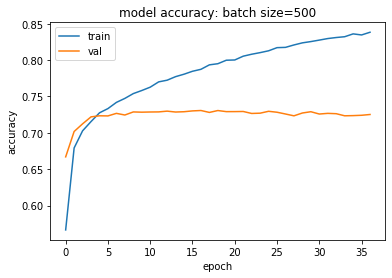

In [91]:
plt.plot(hist_1hl_bsz500.history['acc'])
plt.plot(hist_1hl_bsz500.history['val_acc'])
plt.title('model accuracy: batch size=500')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

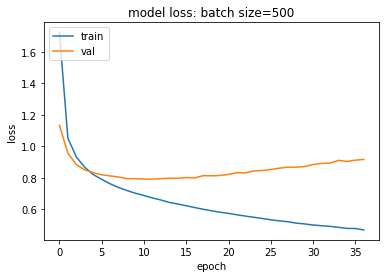

In [92]:
plt.plot(hist_1hl_bsz500.history['loss'])
plt.plot(hist_1hl_bsz500.history['val_loss'])
plt.title('model loss: batch size=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
nn_1hl_bsz500 = KerasClassifier(build_fn=create_model_1hl, epochs=15, batch_size=500, verbose=2)

In [66]:
start = datetime.now()
hist_cross_val_bsz500 = cross_validate(nn_1hl_bsz500, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 22s - loss: 1.6987 - acc: 0.5760
Epoch 2/15
 - 17s - loss: 1.0468 - acc: 0.6818
Epoch 3/15
 - 18s - loss: 0.9260 - acc: 0.7049
Epoch 4/15
 - 18s - loss: 0.8641 - acc: 0.7162
Epoch 5/15
 - 20s - loss: 0.8189 - acc: 0.7267
Epoch 6/15
 - 20s - loss: 0.7842 - acc: 0.7358
Epoch 7/15
 - 20s - loss: 0.7563 - acc: 0.7435
Epoch 8/15
 - 14s - loss: 0.7332 - acc: 0.7506
Epoch 9/15
 - 17s - loss: 0.7160 - acc: 0.7556
Epoch 10/15
 - 20s - loss: 0.6974 - acc: 0.7602
Epoch 11/15
 - 22s - loss: 0.6823 - acc: 0.7643
Epoch 12/15
 - 21s - loss: 0.6663 - acc: 0.7700
Epoch 13/15
 - 20s - loss: 0.6544 - acc: 0.7732
Epoch 14/15
 - 17s - loss: 0.6380 - acc: 0.7791
Epoch 15/15
 - 19s - loss: 0.6272 - acc: 0.7838


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 20s - loss: 1.6925 - acc: 0.5711
Epoch 2/15
 - 20s - loss: 1.0463 - acc: 0.6838
Epoch 3/15
 - 21s - loss: 0.9278 - acc: 0.7059
Epoch 4/15
 - 20s - loss: 0.8604 - acc: 0.7178
Epoch 5/15
 - 20s - loss: 0.8160 - acc: 0.7291
Epoch 6/15
 - 21s - loss: 0.7848 - acc: 0.7362
Epoch 7/15
 - 18s - loss: 0.7577 - acc: 0.7436
Epoch 8/15
 - 19s - loss: 0.7372 - acc: 0.7502
Epoch 9/15
 - 17s - loss: 0.7173 - acc: 0.7544
Epoch 10/15
 - 20s - loss: 0.6986 - acc: 0.7609
Epoch 11/15
 - 21s - loss: 0.6821 - acc: 0.7659
Epoch 12/15
 - 20s - loss: 0.6696 - acc: 0.7703
Epoch 13/15
 - 19s - loss: 0.6577 - acc: 0.7727
Epoch 14/15
 - 21s - loss: 0.6437 - acc: 0.7779
Epoch 15/15
 - 19s - loss: 0.6314 - acc: 0.7818


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 22s - loss: 1.6957 - acc: 0.5741
Epoch 2/15
 - 19s - loss: 1.0319 - acc: 0.6878
Epoch 3/15
 - 21s - loss: 0.9119 - acc: 0.7084
Epoch 4/15
 - 16s - loss: 0.8462 - acc: 0.7230
Epoch 5/15
 - 15s - loss: 0.8021 - acc: 0.7341
Epoch 6/15
 - 17s - loss: 0.7700 - acc: 0.7397
Epoch 7/15
 - 17s - loss: 0.7432 - acc: 0.7482
Epoch 8/15
 - 17s - loss: 0.7199 - acc: 0.7542
Epoch 9/15
 - 16s - loss: 0.7025 - acc: 0.7605
Epoch 10/15
 - 17s - loss: 0.6832 - acc: 0.7641
Epoch 11/15
 - 17s - loss: 0.6675 - acc: 0.7709
Epoch 12/15
 - 17s - loss: 0.6541 - acc: 0.7735
Epoch 13/15
 - 17s - loss: 0.6386 - acc: 0.7796
Epoch 14/15
 - 17s - loss: 0.6266 - acc: 0.7838
Epoch 15/15
 - 17s - loss: 0.6136 - acc: 0.7884


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/15
 - 22s - loss: 1.6916 - acc: 0.5767
Epoch 2/15
 - 21s - loss: 1.0454 - acc: 0.6804
Epoch 3/15
 - 21s - loss: 0.9245 - acc: 0.7033
Epoch 4/15
 - 19s - loss: 0.8601 - acc: 0.7167
Epoch 5/15
 - 20s - loss: 0.8174 - acc: 0.7252
Epoch 6/15
 - 19s - loss: 0.7840 - acc: 0.7339
Epoch 7/15
 - 17s - loss: 0.7581 - acc: 0.7414
Epoch 8/15
 - 20s - loss: 0.7373 - acc: 0.7469
Epoch 9/15
 - 21s - loss: 0.7162 - acc: 0.7534
Epoch 10/15
 - 20s - loss: 0.6970 - acc: 0.7602
Epoch 11/15
 - 20s - loss: 0.6818 - acc: 0.7645
Epoch 12/15
 - 20s - loss: 0.6683 - acc: 0.7702
Epoch 13/15
 - 20s - loss: 0.6552 - acc: 0.7747
Epoch 14/15
 - 21s - loss: 0.6408 - acc: 0.7778
Epoch 15/15
 - 20s - loss: 0.6315 - acc: 0.7824


'0:19:34.124281'

In [67]:
hist_cross_val_bsz500

{'fit_time': array([287.96559715, 296.52046776, 265.34647226, 302.12567043]),
 'score_time': array([5.15920305, 5.34723258, 5.15922093, 6.14064074]),
 'test_accuracy': array([0.72865917, 0.72384098, 0.71418416, 0.73232661]),
 'test_neg_log_loss': array([-0.81071577, -0.82520654, -0.86716871, -0.79934795])}

In [68]:
hist_cross_val_bsz500['test_accuracy'].mean(), hist_cross_val_bsz500['test_neg_log_loss'].mean()

(0.7247527306365278, -0.8256097415425194)

In [77]:
nn_1hl_bsz500 = KerasClassifier(build_fn=create_model_1hl, epochs=30, batch_size=500, verbose=2)

In [79]:
start = datetime.now()
hist_cross_val_bsz500 = cross_validate(nn_1hl_bsz500, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 11s - loss: 1.6911 - acc: 0.5738
Epoch 2/30
 - 7s - loss: 1.0430 - acc: 0.6823
Epoch 3/30
 - 6s - loss: 0.9236 - acc: 0.7051
Epoch 4/30
 - 6s - loss: 0.8618 - acc: 0.7169
Epoch 5/30
 - 7s - loss: 0.8156 - acc: 0.7282
Epoch 6/30
 - 7s - loss: 0.7834 - acc: 0.7355
Epoch 7/30
 - 8s - loss: 0.7587 - acc: 0.7413
Epoch 8/30
 - 8s - loss: 0.7339 - acc: 0.7485
Epoch 9/30
 - 9s - loss: 0.7144 - acc: 0.7544
Epoch 10/30
 - 7s - loss: 0.6969 - acc: 0.7598
Epoch 11/30
 - 8s - loss: 0.6818 - acc: 0.7657
Epoch 12/30
 - 7s - loss: 0.6677 - acc: 0.7699
Epoch 13/30
 - 7s - loss: 0.6514 - acc: 0.7755
Epoch 14/30
 - 7s - loss: 0.6410 - acc: 0.7777
Epoch 15/30
 - 9s - loss: 0.6295 - acc: 0.7826
Epoch 16/30
 - 7s - loss: 0.6188 - acc: 0.7855
Epoch 17/30
 - 7s - loss: 0.6069 - acc: 0.7892
Epoch 18/30
 - 7s - loss: 0.5967 - acc: 0.7933
Epoch 19/30
 - 7s - loss: 0.5869 - acc: 0.7965
Epoch 20/30
 - 8s - loss: 0.5774 - acc: 0.7993
Epoch 21/30
 - 7s - loss: 0.5691 - acc: 0.8023
Epoch 22/30
 - 7s - l

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 11s - loss: 1.7006 - acc: 0.5749
Epoch 2/30
 - 9s - loss: 1.0450 - acc: 0.6825
Epoch 3/30
 - 6s - loss: 0.9275 - acc: 0.7060
Epoch 4/30
 - 9s - loss: 0.8595 - acc: 0.7182
Epoch 5/30
 - 8s - loss: 0.8194 - acc: 0.7271
Epoch 6/30
 - 8s - loss: 0.7847 - acc: 0.7362
Epoch 7/30
 - 8s - loss: 0.7609 - acc: 0.7420
Epoch 8/30
 - 13s - loss: 0.7372 - acc: 0.7494
Epoch 9/30
 - 13s - loss: 0.7166 - acc: 0.7557
Epoch 10/30
 - 18s - loss: 0.7013 - acc: 0.7599
Epoch 11/30
 - 17s - loss: 0.6843 - acc: 0.7657
Epoch 12/30
 - 17s - loss: 0.6679 - acc: 0.7695
Epoch 13/30
 - 15s - loss: 0.6563 - acc: 0.7754
Epoch 14/30
 - 12s - loss: 0.6432 - acc: 0.7773
Epoch 15/30
 - 14s - loss: 0.6316 - acc: 0.7832
Epoch 16/30
 - 15s - loss: 0.6203 - acc: 0.7841
Epoch 17/30
 - 19s - loss: 0.6088 - acc: 0.7898
Epoch 18/30
 - 17s - loss: 0.5991 - acc: 0.7927
Epoch 19/30
 - 16s - loss: 0.5897 - acc: 0.7953
Epoch 20/30
 - 13s - loss: 0.5804 - acc: 0.7991
Epoch 21/30
 - 10s - loss: 0.5699 - acc: 0.8026
Epoch 2

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 13s - loss: 1.7051 - acc: 0.5740
Epoch 2/30
 - 9s - loss: 1.0319 - acc: 0.6860
Epoch 3/30
 - 10s - loss: 0.9116 - acc: 0.7093
Epoch 4/30
 - 10s - loss: 0.8483 - acc: 0.7219
Epoch 5/30
 - 10s - loss: 0.8023 - acc: 0.7327
Epoch 6/30
 - 11s - loss: 0.7703 - acc: 0.7397
Epoch 7/30
 - 11s - loss: 0.7438 - acc: 0.7474
Epoch 8/30
 - 13s - loss: 0.7214 - acc: 0.7537
Epoch 9/30
 - 11s - loss: 0.7017 - acc: 0.7600
Epoch 10/30
 - 10s - loss: 0.6842 - acc: 0.7660
Epoch 11/30
 - 9s - loss: 0.6665 - acc: 0.7703
Epoch 12/30
 - 10s - loss: 0.6538 - acc: 0.7748
Epoch 13/30
 - 9s - loss: 0.6394 - acc: 0.7788
Epoch 14/30
 - 10s - loss: 0.6261 - acc: 0.7838
Epoch 15/30
 - 10s - loss: 0.6145 - acc: 0.7875
Epoch 16/30
 - 9s - loss: 0.6023 - acc: 0.7916
Epoch 17/30
 - 10s - loss: 0.5924 - acc: 0.7942
Epoch 18/30
 - 9s - loss: 0.5837 - acc: 0.7988
Epoch 19/30
 - 12s - loss: 0.5716 - acc: 0.8004
Epoch 20/30
 - 11s - loss: 0.5625 - acc: 0.8050
Epoch 21/30
 - 9s - loss: 0.5537 - acc: 0.8079
Epoch 2

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 9s - loss: 1.7129 - acc: 0.5714
Epoch 2/30
 - 6s - loss: 1.0513 - acc: 0.6799
Epoch 3/30
 - 6s - loss: 0.9287 - acc: 0.7022
Epoch 4/30
 - 7s - loss: 0.8634 - acc: 0.7173
Epoch 5/30
 - 7s - loss: 0.8189 - acc: 0.7260
Epoch 6/30
 - 7s - loss: 0.7852 - acc: 0.7341
Epoch 7/30
 - 7s - loss: 0.7600 - acc: 0.7418
Epoch 8/30
 - 7s - loss: 0.7389 - acc: 0.7462
Epoch 9/30
 - 6s - loss: 0.7177 - acc: 0.7538
Epoch 10/30
 - 6s - loss: 0.7007 - acc: 0.7582
Epoch 11/30
 - 6s - loss: 0.6852 - acc: 0.7642
Epoch 12/30
 - 7s - loss: 0.6697 - acc: 0.7690
Epoch 13/30
 - 6s - loss: 0.6580 - acc: 0.7725
Epoch 14/30
 - 6s - loss: 0.6439 - acc: 0.7768
Epoch 15/30
 - 6s - loss: 0.6334 - acc: 0.7810
Epoch 16/30
 - 6s - loss: 0.6225 - acc: 0.7861
Epoch 17/30
 - 6s - loss: 0.6089 - acc: 0.7895
Epoch 18/30
 - 6s - loss: 0.6019 - acc: 0.7929
Epoch 19/30
 - 6s - loss: 0.5895 - acc: 0.7954
Epoch 20/30
 - 7s - loss: 0.5804 - acc: 0.7996
Epoch 21/30
 - 6s - loss: 0.5725 - acc: 0.8005
Epoch 22/30
 - 7s - lo

'0:18:38.121480'

In [80]:
hist_cross_val_bsz500

{'fit_time': array([228.25806761, 380.2881372 , 295.49103117, 199.38756704]),
 'score_time': array([2.8459146 , 5.28574038, 2.65137863, 3.53681755]),
 'test_accuracy': array([0.72155601, 0.72342293, 0.71518776, 0.7242115 ]),
 'test_neg_log_loss': array([-0.88508471, -0.89210922, -0.9567579 , -0.87393058])}

In [81]:
hist_cross_val_bsz500['test_accuracy'].mean(), hist_cross_val_bsz500['test_neg_log_loss'].mean()

(0.7210945488753802, -0.9019706013860028)

In [63]:
nn_1hl_bsz3000 = KerasClassifier(build_fn=create_model_1hl, epochs=100, batch_size=3000, verbose=2)

In [64]:
start = datetime.now()
hist_1hl_bsz3000 = nn_1hl_bsz3000.fit(X, y, validation_split=0.25, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 11s - loss: 2.6318 - acc: 0.4131 - val_loss: 2.0186 - val_acc: 0.5600
Epoch 2/100
 - 9s - loss: 1.7554 - acc: 0.5910 - val_loss: 1.4564 - val_acc: 0.6420
Epoch 3/100
 - 9s - loss: 1.3821 - acc: 0.6373 - val_loss: 1.2288 - val_acc: 0.6613
Epoch 4/100
 - 9s - loss: 1.1962 - acc: 0.6599 - val_loss: 1.0865 - val_acc: 0.6840
Epoch 5/100
 - 9s - loss: 1.0902 - acc: 0.6768 - val_loss: 1.0202 - val_acc: 0.6950
Epoch 6/100
 - 9s - loss: 1.0225 - acc: 0.6866 - val_loss: 0.9736 - val_acc: 0.7008
Epoch 7/100
 - 9s - loss: 0.9759 - acc: 0.6965 - val_loss: 0.9576 - val_acc: 0.7010
Epoch 8/100
 - 10s - loss: 0.9362 - acc: 0.7037 - val_loss: 0.9186 - val_acc: 0.7116
Epoch 9/100
 - 10s - loss: 0.9061 - acc: 0.7102 - val_loss: 0.8913 - val_acc: 0.7151
Epoch 10/100
 - 10s - loss: 0.8806 - acc: 0.7152 - val_loss: 0.8760 - val_acc: 0.7183
Epoch 11/100
 - 11s - loss: 0.8561 - acc: 0.7200 - val_loss: 0.8656 - val_acc: 0.7218
Epoch 12/100
 - 10s

'0:08:52.832307'

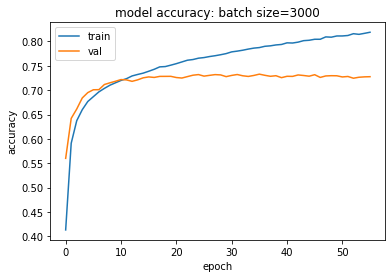

In [89]:
plt.plot(hist_1hl_bsz3000.history['acc'])
plt.plot(hist_1hl_bsz3000.history['val_acc'])
plt.title('model accuracy: batch size=3000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

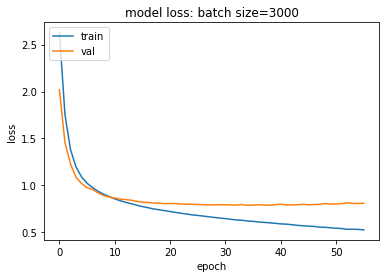

In [90]:
plt.plot(hist_1hl_bsz3000.history['loss'])
plt.plot(hist_1hl_bsz3000.history['val_loss'])
plt.title('model loss: batch size=3000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
nn_1hl_bsz3000 = KerasClassifier(build_fn=create_model_1hl, epochs=30, batch_size=3000, verbose=2)

In [70]:
start = datetime.now()
hist_cross_val_bsz3000 = cross_validate(nn_1hl_bsz3000, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 11s - loss: 2.6305 - acc: 0.4162
Epoch 2/30
 - 9s - loss: 1.7367 - acc: 0.5888
Epoch 3/30
 - 8s - loss: 1.3678 - acc: 0.6387
Epoch 4/30
 - 9s - loss: 1.1814 - acc: 0.6630
Epoch 5/30
 - 9s - loss: 1.0788 - acc: 0.6808
Epoch 6/30
 - 9s - loss: 1.0130 - acc: 0.6908
Epoch 7/30
 - 9s - loss: 0.9690 - acc: 0.6974
Epoch 8/30
 - 8s - loss: 0.9284 - acc: 0.7043
Epoch 9/30
 - 9s - loss: 0.9003 - acc: 0.7102
Epoch 10/30
 - 9s - loss: 0.8736 - acc: 0.7163
Epoch 11/30
 - 9s - loss: 0.8516 - acc: 0.7216
Epoch 12/30
 - 9s - loss: 0.8332 - acc: 0.7248
Epoch 13/30
 - 9s - loss: 0.8140 - acc: 0.7296
Epoch 14/30
 - 9s - loss: 0.7993 - acc: 0.7332
Epoch 15/30
 - 9s - loss: 0.7865 - acc: 0.7372
Epoch 16/30
 - 9s - loss: 0.7704 - acc: 0.7398
Epoch 17/30
 - 9s - loss: 0.7599 - acc: 0.7425
Epoch 18/30
 - 9s - loss: 0.7502 - acc: 0.7442
Epoch 19/30
 - 8s - loss: 0.7392 - acc: 0.7483
Epoch 20/30
 - 8s - loss: 0.7269 - acc: 0.7518
Epoch 21/30
 - 8s - loss: 0.7193 - acc: 0.7537
Epoch 22/30
 - 9s - l

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 10s - loss: 2.5965 - acc: 0.4315
Epoch 2/30
 - 8s - loss: 1.7207 - acc: 0.5967
Epoch 3/30
 - 8s - loss: 1.3553 - acc: 0.6389
Epoch 4/30
 - 8s - loss: 1.1745 - acc: 0.6634
Epoch 5/30
 - 9s - loss: 1.0756 - acc: 0.6782
Epoch 6/30
 - 9s - loss: 1.0105 - acc: 0.6927
Epoch 7/30
 - 8s - loss: 0.9647 - acc: 0.6991
Epoch 8/30
 - 9s - loss: 0.9238 - acc: 0.7082
Epoch 9/30
 - 8s - loss: 0.8964 - acc: 0.7131
Epoch 10/30
 - 8s - loss: 0.8703 - acc: 0.7180
Epoch 11/30
 - 8s - loss: 0.8489 - acc: 0.7222
Epoch 12/30
 - 9s - loss: 0.8281 - acc: 0.7273
Epoch 13/30
 - 8s - loss: 0.8094 - acc: 0.7319
Epoch 14/30
 - 8s - loss: 0.7959 - acc: 0.7358
Epoch 15/30
 - 8s - loss: 0.7827 - acc: 0.7379
Epoch 16/30
 - 8s - loss: 0.7701 - acc: 0.7416
Epoch 17/30
 - 8s - loss: 0.7552 - acc: 0.7459
Epoch 18/30
 - 8s - loss: 0.7452 - acc: 0.7483
Epoch 19/30
 - 8s - loss: 0.7342 - acc: 0.7514
Epoch 20/30
 - 9s - loss: 0.7244 - acc: 0.7536
Epoch 21/30
 - 9s - loss: 0.7139 - acc: 0.7583
Epoch 22/30
 - 9s - l

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 11s - loss: 2.6372 - acc: 0.4306
Epoch 2/30
 - 9s - loss: 1.7341 - acc: 0.6005
Epoch 3/30
 - 9s - loss: 1.3582 - acc: 0.6410
Epoch 4/30
 - 9s - loss: 1.1719 - acc: 0.6664
Epoch 5/30
 - 8s - loss: 1.0632 - acc: 0.6840
Epoch 6/30
 - 9s - loss: 0.9995 - acc: 0.6955
Epoch 7/30
 - 8s - loss: 0.9502 - acc: 0.7036
Epoch 8/30
 - 9s - loss: 0.9150 - acc: 0.7103
Epoch 9/30
 - 8s - loss: 0.8875 - acc: 0.7149
Epoch 10/30
 - 9s - loss: 0.8609 - acc: 0.7207
Epoch 11/30
 - 8s - loss: 0.8365 - acc: 0.7261
Epoch 12/30
 - 9s - loss: 0.8178 - acc: 0.7306
Epoch 13/30
 - 9s - loss: 0.8000 - acc: 0.7337
Epoch 14/30
 - 8s - loss: 0.7832 - acc: 0.7389
Epoch 15/30
 - 10s - loss: 0.7680 - acc: 0.7433
Epoch 16/30
 - 8s - loss: 0.7564 - acc: 0.7464
Epoch 17/30
 - 9s - loss: 0.7434 - acc: 0.7489
Epoch 18/30
 - 8s - loss: 0.7327 - acc: 0.7514
Epoch 19/30
 - 9s - loss: 0.7185 - acc: 0.7562
Epoch 20/30
 - 8s - loss: 0.7099 - acc: 0.7573
Epoch 21/30
 - 9s - loss: 0.7003 - acc: 0.7614
Epoch 22/30
 - 8s - 

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/30
 - 10s - loss: 2.6146 - acc: 0.4195
Epoch 2/30
 - 8s - loss: 1.7362 - acc: 0.5894
Epoch 3/30
 - 8s - loss: 1.3726 - acc: 0.6307
Epoch 4/30
 - 8s - loss: 1.1883 - acc: 0.6584
Epoch 5/30
 - 8s - loss: 1.0816 - acc: 0.6759
Epoch 6/30
 - 8s - loss: 1.0195 - acc: 0.6873
Epoch 7/30
 - 8s - loss: 0.9703 - acc: 0.6966
Epoch 8/30
 - 8s - loss: 0.9301 - acc: 0.7044
Epoch 9/30
 - 8s - loss: 0.8991 - acc: 0.7103
Epoch 10/30
 - 8s - loss: 0.8745 - acc: 0.7157
Epoch 11/30
 - 8s - loss: 0.8491 - acc: 0.7211
Epoch 12/30
 - 8s - loss: 0.8306 - acc: 0.7255
Epoch 13/30
 - 8s - loss: 0.8131 - acc: 0.7290
Epoch 14/30
 - 8s - loss: 0.7973 - acc: 0.7331
Epoch 15/30
 - 8s - loss: 0.7844 - acc: 0.7388
Epoch 16/30
 - 8s - loss: 0.7680 - acc: 0.7416
Epoch 17/30
 - 8s - loss: 0.7583 - acc: 0.7433
Epoch 18/30
 - 8s - loss: 0.7460 - acc: 0.7475
Epoch 19/30
 - 8s - loss: 0.7351 - acc: 0.7506
Epoch 20/30
 - 8s - loss: 0.7267 - acc: 0.7520
Epoch 21/30
 - 9s - loss: 0.7140 - acc: 0.7574
Epoch 22/30
 - 9s - l

'0:17:26.424329'

In [71]:
hist_cross_val_bsz3000

{'fit_time': array([261.35864925, 257.30623889, 261.6889286 , 255.01776266]),
 'score_time': array([2.70130897, 2.69250774, 2.65195894, 2.76911116]),
 'test_accuracy': array([0.72861739, 0.7270181 , 0.71464414, 0.73307956]),
 'test_neg_log_loss': array([-0.79988328, -0.80339764, -0.85310992, -0.79092039])}

In [72]:
hist_cross_val_bsz3000['test_accuracy'].mean(), hist_cross_val_bsz3000['test_neg_log_loss'].mean()

(0.7258397986469234, -0.8118278074416612)

In [73]:
nn_1hl_bsz3000 = KerasClassifier(build_fn=create_model_1hl, epochs=35, batch_size=3000, verbose=2)

In [74]:
start = datetime.now()
hist_cross_val_bsz3000 = cross_validate(nn_1hl_bsz3000, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/35
 - 11s - loss: 2.6549 - acc: 0.4212
Epoch 2/35
 - 9s - loss: 1.7424 - acc: 0.5983
Epoch 3/35
 - 9s - loss: 1.3719 - acc: 0.6391
Epoch 4/35
 - 9s - loss: 1.1845 - acc: 0.6655
Epoch 5/35
 - 9s - loss: 1.0805 - acc: 0.6793
Epoch 6/35
 - 9s - loss: 1.0121 - acc: 0.6901
Epoch 7/35
 - 9s - loss: 0.9664 - acc: 0.6987
Epoch 8/35
 - 9s - loss: 0.9289 - acc: 0.7059
Epoch 9/35
 - 9s - loss: 0.9003 - acc: 0.7119
Epoch 10/35
 - 9s - loss: 0.8714 - acc: 0.7169
Epoch 11/35
 - 9s - loss: 0.8511 - acc: 0.7221
Epoch 12/35
 - 8s - loss: 0.8329 - acc: 0.7252
Epoch 13/35
 - 9s - loss: 0.8135 - acc: 0.7301
Epoch 14/35
 - 9s - loss: 0.7977 - acc: 0.7337
Epoch 15/35
 - 9s - loss: 0.7831 - acc: 0.7378
Epoch 16/35
 - 9s - loss: 0.7707 - acc: 0.7415
Epoch 17/35
 - 9s - loss: 0.7585 - acc: 0.7443
Epoch 18/35
 - 9s - loss: 0.7473 - acc: 0.7468
Epoch 19/35
 - 9s - loss: 0.7362 - acc: 0.7497
Epoch 20/35
 - 9s - loss: 0.7271 - acc: 0.7529
Epoch 21/35
 - 9s - loss: 0.7179 - acc: 0.7552
Epoch 22/35
 - 9s - l

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/35
 - 10s - loss: 2.5972 - acc: 0.4353
Epoch 2/35
 - 8s - loss: 1.7259 - acc: 0.5978
Epoch 3/35
 - 9s - loss: 1.3664 - acc: 0.6393
Epoch 4/35
 - 9s - loss: 1.1807 - acc: 0.6636
Epoch 5/35
 - 9s - loss: 1.0770 - acc: 0.6809
Epoch 6/35
 - 9s - loss: 1.0102 - acc: 0.6930
Epoch 7/35
 - 9s - loss: 0.9645 - acc: 0.6992
Epoch 8/35
 - 8s - loss: 0.9249 - acc: 0.7076
Epoch 9/35
 - 8s - loss: 0.8965 - acc: 0.7130
Epoch 10/35
 - 8s - loss: 0.8719 - acc: 0.7186
Epoch 11/35
 - 8s - loss: 0.8470 - acc: 0.7248
Epoch 12/35
 - 8s - loss: 0.8290 - acc: 0.7261
Epoch 13/35
 - 8s - loss: 0.8136 - acc: 0.7301
Epoch 14/35
 - 8s - loss: 0.7951 - acc: 0.7342
Epoch 15/35
 - 8s - loss: 0.7817 - acc: 0.7389
Epoch 16/35
 - 8s - loss: 0.7689 - acc: 0.7419
Epoch 17/35
 - 8s - loss: 0.7576 - acc: 0.7445
Epoch 18/35
 - 8s - loss: 0.7466 - acc: 0.7481
Epoch 19/35
 - 8s - loss: 0.7351 - acc: 0.7518
Epoch 20/35
 - 8s - loss: 0.7261 - acc: 0.7536
Epoch 21/35
 - 8s - loss: 0.7185 - acc: 0.7563
Epoch 22/35
 - 9s - l

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/35
 - 12s - loss: 2.5927 - acc: 0.4250
Epoch 2/35
 - 8s - loss: 1.7134 - acc: 0.6002
Epoch 3/35
 - 9s - loss: 1.3483 - acc: 0.6415
Epoch 4/35
 - 9s - loss: 1.1665 - acc: 0.6669
Epoch 5/35
 - 9s - loss: 1.0642 - acc: 0.6834
Epoch 6/35
 - 8s - loss: 0.9993 - acc: 0.6945
Epoch 7/35
 - 10s - loss: 0.9503 - acc: 0.7042
Epoch 8/35
 - 8s - loss: 0.9167 - acc: 0.7112
Epoch 9/35
 - 8s - loss: 0.8838 - acc: 0.7189
Epoch 10/35
 - 8s - loss: 0.8595 - acc: 0.7217
Epoch 11/35
 - 9s - loss: 0.8364 - acc: 0.7253
Epoch 12/35
 - 9s - loss: 0.8172 - acc: 0.7313
Epoch 13/35
 - 9s - loss: 0.7979 - acc: 0.7363
Epoch 14/35
 - 9s - loss: 0.7822 - acc: 0.7392
Epoch 15/35
 - 8s - loss: 0.7666 - acc: 0.7435
Epoch 16/35
 - 9s - loss: 0.7542 - acc: 0.7479
Epoch 17/35
 - 8s - loss: 0.7434 - acc: 0.7496
Epoch 18/35
 - 9s - loss: 0.7306 - acc: 0.7532
Epoch 19/35
 - 8s - loss: 0.7216 - acc: 0.7554
Epoch 20/35
 - 9s - loss: 0.7094 - acc: 0.7605
Epoch 21/35
 - 8s - loss: 0.7012 - acc: 0.7612
Epoch 22/35
 - 9s - 

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/35
 - 10s - loss: 2.6163 - acc: 0.4156
Epoch 2/35
 - 8s - loss: 1.7494 - acc: 0.5940
Epoch 3/35
 - 9s - loss: 1.3761 - acc: 0.6350
Epoch 4/35
 - 8s - loss: 1.1895 - acc: 0.6587
Epoch 5/35
 - 8s - loss: 1.0873 - acc: 0.6750
Epoch 6/35
 - 8s - loss: 1.0226 - acc: 0.6870
Epoch 7/35
 - 8s - loss: 0.9725 - acc: 0.6962
Epoch 8/35
 - 9s - loss: 0.9378 - acc: 0.7033
Epoch 9/35
 - 8s - loss: 0.9050 - acc: 0.7083
Epoch 10/35
 - 9s - loss: 0.8771 - acc: 0.7153
Epoch 11/35
 - 9s - loss: 0.8579 - acc: 0.7201
Epoch 12/35
 - 9s - loss: 0.8338 - acc: 0.7240
Epoch 13/35
 - 8s - loss: 0.8164 - acc: 0.7305
Epoch 14/35
 - 8s - loss: 0.8034 - acc: 0.7323
Epoch 15/35
 - 8s - loss: 0.7886 - acc: 0.7356
Epoch 16/35
 - 8s - loss: 0.7744 - acc: 0.7401
Epoch 17/35
 - 8s - loss: 0.7604 - acc: 0.7428
Epoch 18/35
 - 8s - loss: 0.7509 - acc: 0.7453
Epoch 19/35
 - 9s - loss: 0.7388 - acc: 0.7488
Epoch 20/35
 - 9s - loss: 0.7277 - acc: 0.7523
Epoch 21/35
 - 8s - loss: 0.7187 - acc: 0.7554
Epoch 22/35
 - 8s - l

'0:20:16.923237'

In [75]:
hist_cross_val_bsz3000

{'fit_time': array([307.4364078 , 298.6222384 , 307.45467424, 291.04990983]),
 'score_time': array([2.75947452, 3.44154406, 2.78531218, 3.07185578]),
 'test_accuracy': array([0.71821335, 0.72584758, 0.71836581, 0.7295658 ]),
 'test_neg_log_loss': array([-0.80999702, -0.80100904, -0.85313304, -0.79415451])}

In [76]:
hist_cross_val_bsz3000['test_accuracy'].mean(), hist_cross_val_bsz3000['test_neg_log_loss'].mean()

(0.7229981343539086, -0.8145734027579926)